# Evaluation

In [1]:
import pickle
import numpy as np

### F1

In [2]:
file_name = 'BERT_neg4_reduced'

In [3]:
with open(f'../../predictions/Retrievals/Retrieval_{file_name}_dev.pickle', 'rb') as f:
  final_dev_predictions = pickle.load(f)

len(final_dev_predictions)

154

In [4]:
import pickle
with open(f'../../predictions/Retrievals/Retrieval_{file_name}_test.pickle', 'rb') as f:
  final_test_predictions = pickle.load(f)

len(final_test_predictions)

154

In [5]:
import pickle
with open(f'../../predictions/Retrievals/Retrieval_{file_name}_future.pickle', 'rb') as f:
  final_future_predictions = pickle.load(f)

len(final_future_predictions)

153

In [6]:
import json
with open ('../../data/raw/dev-claims.json') as f:
    dev_claims = json.load(f)

print(len(dev_claims))


with open ('../../data/curated/test_claims2.json') as f:
    test_claims = json.load(f)
  
print(len(test_claims))


with open ('../../data/raw/test-claims-unlabelled.json') as f:
    future_claims = json.load(f)
  
print(len(future_claims))

154
154
153


In [7]:
dev_claims_obs = {claim:dev_claims[claim]['evidences'] for claim in dev_claims}
test_claims_obs = {claim:test_claims[claim]['evidences'] for claim in test_claims}

In [8]:
K = 5

In [9]:
dev_claims_pred = {}

for claim in final_dev_predictions:
  # evid_list = [x[0] for x in final_dev_predictions[claim]['evidences']]
  evid_list = [x[0] for x in final_dev_predictions[claim]]


  dev_claims_pred[claim] = evid_list[:K]


test_claims_pred = {}

for claim in final_test_predictions:
  # evid_list = [x[0] for x in final_test_predictions[claim]['evidences']]
  evid_list = [x[0] for x in final_test_predictions[claim]]

  test_claims_pred[claim] = evid_list[:K]

In [10]:
def F1(observed, predicted):
  tp = len([x for x in predicted if x in observed])
  fp = len([x for x in predicted if x not in observed])
  fn = len([x for x in observed if x not in predicted])

  try:
    recall = tp / (tp+fn)

    precision = tp / (tp+fp)
    
    f1 = 2*(precision*recall)/(precision+recall)
  except:
    f1 = 0

  return f1

In [11]:
F1_list = list()
for claim in dev_claims_pred:

  F1_list.append(F1(dev_claims_obs[claim], dev_claims_pred[claim]))

np.mean(F1_list)

0.0

In [12]:
F1_list_test = list()
for claim in test_claims_pred:

  F1_list_test.append(F1(test_claims_obs[claim], test_claims_pred[claim]))

np.mean(F1_list_test)

0.0

### Accuracy

In [13]:
ENCODING = {'REFUTES': 0, 'DISPUTED': 1, 'NOT_ENOUGH_INFO': 2, 'SUPPORTS': 3}
DECODING = {ENCODING[key]:key for key in ENCODING}

In [14]:
def get_accur(predictions, claims):

  accurate = 0
  n = 0

  for id in claims:

    observed_label = claims[id]['claim_label']   
    
    sum_logits = [sum([predictions[id][j][i] for j in range(len(predictions[id]))]) for i in range(len(predictions[id][0]))]
    classified_label_index = np.argmax(sum_logits)
    classified_label = DECODING[classified_label_index]

    predicted_label = classified_label

    n += 1
    if predicted_label == observed_label:
      accurate += 1

  print('accuracy:', accurate/n)

In [15]:
def get_accur_from_pred_retrievals(predictions, claims):

  accurate = 0
  n = 0

  for id in claims:

    observed_label = claims[id]['claim_label']    
    
    sum_logits = [sum([predictions[id][j][i] for j in range(K)]) for i in range(len(predictions[id][0]))]
    classified_label_index = np.argmax(sum_logits)
    classified_label = DECODING[classified_label_index]

    predicted_label = classified_label

    n += 1
    if predicted_label == observed_label:
      accurate += 1

  print('accuracy:', accurate/n)

In [16]:
CLASSIF_MODEL = "BERT"
RETRIEV_MODEL = "bert"

In [17]:
with open(f'../../predictions/Classifications/Classification_{CLASSIF_MODEL}_dev.pickle', 'rb') as f:
    dev_classif = pickle.load(f)

with open(f'../../predictions/Classifications/Classification_{CLASSIF_MODEL}_test.pickle', 'rb') as f:
    test_classif = pickle.load(f)

with open(f'../../predictions/Classifications/Classification_{CLASSIF_MODEL}_{RETRIEV_MODEL}5_devp.pickle', 'rb') as f:
    dev_classif_p = pickle.load(f)

with open(f'../../predictions/Classifications/Classification_{CLASSIF_MODEL}_{RETRIEV_MODEL}5_testp.pickle', 'rb') as f:
    test_classif_p = pickle.load(f)

with open(f'../../predictions/Classifications/Classification_{CLASSIF_MODEL}_{RETRIEV_MODEL}5_futurep.pickle', 'rb') as f:
    future_classif = pickle.load(f)

In [18]:
K=1

In [19]:
get_accur(dev_classif, dev_claims)
get_accur(test_classif, test_claims)
get_accur_from_pred_retrievals(dev_classif_p, dev_claims)
get_accur_from_pred_retrievals(test_classif_p, test_claims)

accuracy: 0.525974025974026
accuracy: 0.5454545454545454
accuracy: 0.5194805194805194
accuracy: 0.5324675324675324


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
pred = []
obs = []
for claim in test_classif_p:
    
    sum_test_classif = [sum([test_classif_p[claim][j][i] for j in range(2)]) for i in range(4)]


    pred.append(DECODING[np.argmax(sum_test_classif)])
    obs.append(test_claims[claim]['claim_label'])

<Figure size 640x480 with 0 Axes>

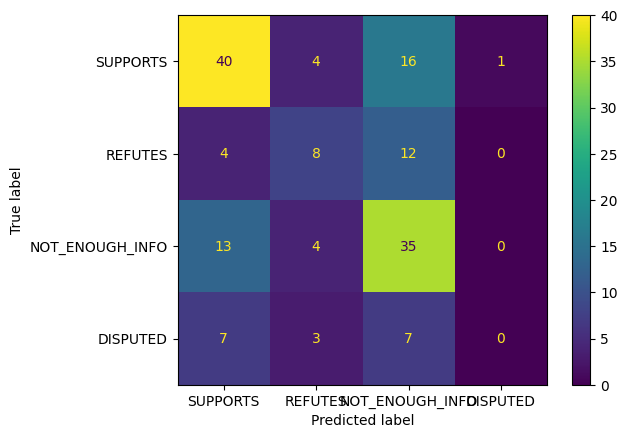

In [38]:
matrix = ConfusionMatrixDisplay(confusion_matrix(obs, pred, labels = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'DISPUTED']), display_labels = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'DISPUTED'])

matrix.plot()